<B><H2> HOUSE PRICE ESTIMATOR </H2></B><H5>TENSORFLOW REGRESSION SEQUENTIAL DNN MODEL</H5>


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import docker
import requests
import json
import numpy as np
import pandas as pd



#TENSORFLOW API
import tensorflow as tf
import tensorflow_data_validation as tfdv
# Feature Engineering
from tensorflow import feature_column as fc
from keras.models import Sequential
from keras import layers
from keras import utils
# TF Dataset for input pipeline
import tensorflow_datasets as tfds
# If using GPU use the below config
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0],True)

# VISUALISATION API
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn is a Python data visualization library based on matplotlib.

# Import train_test_split function from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Used to calculate stats such as Z score, standard deviation & Perform BoxCox Transformations etc.
from scipy import stats
from scipy import special
# Used to calculate MSE
from sklearn.metrics import mean_squared_error

city_list = ["Melbourne", "Sydney","Brisbane","Perth","Adelaide","Hobart"]
city = city_list[0]

<H5> READ THE DATA INTO PANDAS DATAFRAME.</H5> Remove any NULL values

In [2]:
# Import data from CSV into pandas DF
df= pd.read_csv(f"data/{city}/{city}_area.csv")
# Check if there any NULL or NaN values
df.isnull().sum()
# Drop any NA values
df = df.dropna(how='any',axis=0)
# Check that there is no longer Null values
df.isnull().sum()
# Look at DF to get a feel of data
df.head(10)

,Street,Address,Suburb,State,Postcode,Type,Date,Method,Price,Bedrooms,Bathrooms,Cars,Area,Agent,Latitude,Longitude,Distance
0,6 Clifton Street,ABERFELDIE VIC 3040,ABERFELDIE,VIC,3040,House,25-Jun-22,private treaty,1810000,4,2,3,535,MATTHEWS.,-37.761302,144.891030,8.651315
1,14 Batman Street,ABERFELDIE VIC 3040,ABERFELDIE,VIC,3040,House,21-May-22,auction,2101000,4,3,2,650,Woodards Ascot Vale,-37.755418,144.893808,8.941133
2,12 Batman Street,ABERFELDIE VIC 3040,ABERFELDIE,VIC,3040,House,9-Apr-22,auction,1900000,4,2,2,650,Nelson Alexander Essendon,-37.755418,144.893808,8.941133
3,24 Clifton Street,ABERFELDIE VIC 3040,ABERFELDIE,VIC,3040,House,1-Apr-22,auction,2000000,3,2,5,640,Barry Plant Essendon,-37.761302,144.891030,8.651315
4,34 Caroline Street,ABERFELDIE VIC 3040,ABERFELDIE,VIC,3040,House,26-Mar-22,auction,2981000,4,3,3,1017,Ray White Sunbury Pty Ltd,-37.759417,144.892162,8.723874
5,3 Beatrice Avenue,ABERFELDIE VIC 3040,ABERFELDIE,VIC,3040,House,15-Mar-22,private treaty,2540000,5,4,4,613,Jellis Craig Moonee Valley,-37.753983,144.889504,9.317378
6,1 Vida Street,ABERFELDIE VIC 3040,ABERFELDIE,VIC,3040,House,4-Mar-22,private treaty,1855000,4,2,2,569,McDonald Upton,-37.755976,144.898742,8.604382
7,37 Clifton Street,ABERFELDIE VIC 3040,ABERFELDIE,VIC,3040,House,19-Feb-22,auction,1945000,4,3,2,810,Barry Plant Essendon,-37.761302,144.891030,8.651315
8,104 Fawkner Street,ABERFELDIE VIC 3040,ABERFELDIE,VIC,3040,House,19-Feb-22,auction,2007000,3,2,1,481,Barry Plant Essendon,-37.757372,144.896145,8.641993
9,5 Muldowney Street,ABERFELDIE VIC 3040,ABERFELDIE,VIC,3040,House,5-Feb-22,auction,2501000,4,2,3,482,Nelson Alexander Essendon,-37.758229,144.896914,8.526209


<H3> <B> EXPLORATORY DATA ANALYSIS (EDA) </B></H3>

Explore Data statistics using Pandas

In [ ]:
df.describe()

Explore Data Types using Pandas

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117520 entries, 0 to 117519
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Street     117520 non-null  object 
 1   Address    117520 non-null  object 
 2   Suburb     117520 non-null  object 
 3   State      117520 non-null  object 
 4   Postcode   117520 non-null  int64  
 5   Type       117520 non-null  object 
 6   Date       117520 non-null  object 
 7   Method     117520 non-null  object 
 8   Price      117520 non-null  int64  
 9   Bedrooms   117520 non-null  int64  
 10  Bathrooms  117520 non-null  int64  
 11  Cars       117520 non-null  int64  
 12  Area       117520 non-null  int64  
 13  Agent      117520 non-null  object 
 14  Latitude   117520 non-null  float64
 15  Longitude  117520 non-null  float64
 16  Distance   117520 non-null  float64
dtypes: float64(3), int64(6), object(8)
memory usage: 15.2+ MB


Explore Data statistics ,schema & types using TensorFlow Data Validation (TFDV)

In [ ]:
data = tfdv.generate_statistics_from_csv(f"data/{city}/{city}_area.csv")
tfdv.visualize_statistics(data)
schema = tfdv.infer_schema(statistics=data)
tfdv.display_schema(schema=schema)
# Check eval data for errors by validating the eval data stats using the previously inferred schema.
anomalies = tfdv.validate_statistics(statistics=data, schema=schema)
tfdv.display_anomalies(anomalies)

Categorise fields into CATEGORICAL,NUMERICAL & to be DROPPED

In [4]:
# Above there is a combination of categorical & numerical features with 'Price' being the label. We will need to classify the 
# features into the following:
num_feat = ['Bedrooms','Bathrooms','Cars','Area','Latitude','Longitude','Distance','Price','Date']
cat_feat = ['Suburb','Type','Method']
drop_feat = ['Street','Address','State','Postcode','Agent']

# Drop features that are not required
if set(drop_feat).issubset(df.columns):
  df = df.drop(drop_feat, axis = 1) 

Explore Relationships between Numerical Features

In [ ]:
sns.pairplot(data = df[num_feat], height=3,diag_kind='kde')

Feature correlation using Heat Map for visualisation & list all features related to Target(Price) prior to any feature engineering or transformation

Bathrooms    0.10
Bedrooms     0.08
Cars         0.04
Area         0.00
Longitude   -0.00
Latitude    -0.02
Distance    -0.06
Name: Price, dtype: float64

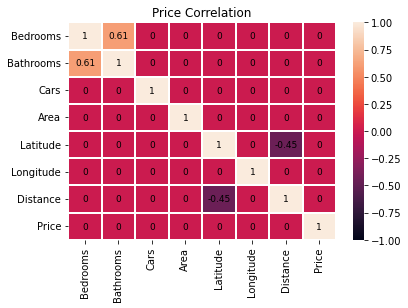

In [5]:
# Heatmap for all the remaining numerical data including the target 'Price'
# Define the heatmap parameters
pd.options.display.float_format = "{:,.2f}".format

# Define correlation matrix
corr_matrix = df[num_feat].corr()

# Replace correlation < |0.3| by 0 for a better visibility
corr_matrix[(corr_matrix < 0.3) & (corr_matrix > -0.3)] = 0

# plot the heatmap
sns.heatmap(corr_matrix, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 9, "color": "black"},annot=True)
plt.title("Price Correlation")

## Lets visualize individually 

corr =df.corr()["Price"].sort_values(ascending = False)[1:len(num_feat)] ## selecting cols other than Saleprice, LogPrice
corr

Check Price Distribution

In [ ]:
sns.displot(df['Price'],kde = False)

Check Skew of all features

In [6]:
num_feat = df.dtypes[df.dtypes != 'object'].index
skew_feats = df[num_feat].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'skew': skew_feats})
skewness

,skew
Price,297.75
Area,284.71
Cars,1.65
Bathrooms,1.15
Distance,0.82
Bedrooms,0.49
Longitude,-0.46
Latitude,-0.61


<H3> <B>FEATURE ENGINEERING & TRANSFORMATION </B></H3>

1. Crafting new Feature YEAR from DATE
2. Crafing new Feature 'LogPrice' from 'Price' to reduce significant skew present in 'Price'
3. Transforming Feature 'Area' from 'Price' to reduce significant skew present in 'Price'


In [7]:
df['Date']= df['Date'].astype('datetime64[ns]')
df['Year'] = df['Date'].dt.year
# df['PricePerSqm'] = df['Price']/df['Area']
df['BoxPrice'], lam = stats.boxcox(df['Price'])
print('Optimal lambda', lam)


#df["LogPrice"] = np.log10(df["Price"])
# Added Area after I realised that Area has large skew, hence applying log10 to reduce Skew & make it more Gausian/normal distribution
# then applu Z score as it works best on Normal/Gausian Distribution
df['LogArea'],lamArea = stats.boxcox(df['Area'])
df = df.drop(['Price','Date','Area'], axis = 1)

Optimal lambda 0.01292558410620058


Check Skew/distribution After Transformation

In [8]:
num_feat = ['Bedrooms','Bathrooms','Cars','LogArea','Latitude','Longitude','Distance','Year','BoxPrice']
#num_feat = df.dtypes[df.dtypes != 'object'].index
skew_feats = df[num_feat].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'skew': skew_feats})
skewness

,skew
Cars,1.65
Bathrooms,1.15
Distance,0.82
Bedrooms,0.49
BoxPrice,0.05
LogArea,-0.34
Longitude,-0.46
Latitude,-0.61
Year,-0.82


Check Distribution Before & After Transformation

In [ ]:
sns.displot(df['Price'],kde = False)
sns.displot(df['BoxPrice'],kde = False)
sns.displot(df['Area'],kde = False)
sns.displot(df['LogArea'],kde = False)


<H3> <B> ANOMALY DETECTION & REMOVAL </B></H3>

Filter out Outliers using either Z Score Method (normal discribution) or IQR method.

In [9]:
method = 'Zscore'
# Interquartile range (IQR) method should be used for NON normal distribution

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

if method == 'Zscore':
  #df = df[(np.abs(stats.zscore(df['Price'])) < 3)]
  df = df[(np.abs(stats.zscore(df[num_feat])) < 3).all(axis=1)]
  
else:
  df = remove_outlier(df, num_feat)

<h4> Explore Data after removing anomalies & using Log10 on Price to reduce skew </H4>
Check Skew/Distribution after we have performed BOTH Transformation & Anomaly removal

In [ ]:
#sns.pairplot(data = df[num_feat], height=3,diag_kind='kde')

df.describe()

num_feat = df.dtypes[df.dtypes != 'object'].index
skew_feats = df[num_feat].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'skew': skew_feats})
skewness

Check Correlation after we have performed BOTH Transformation & Anomaly removal

Bedrooms     0.31
Bathrooms    0.30
LogArea      0.21
Year         0.20
Cars         0.15
Longitude    0.06
Latitude    -0.09
Distance    -0.36
Name: BoxPrice, dtype: float64

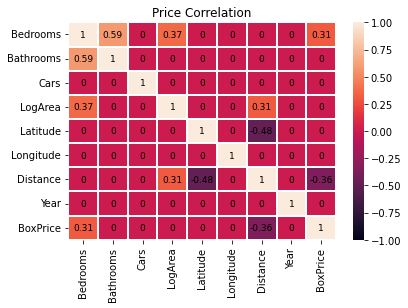

In [10]:
# Heatmap for all the remaining numerical data including the target 'Price'
# Define the heatmap parameters
pd.options.display.float_format = "{:,.2f}".format
# Define correlation matrix
corr_matrix = df[num_feat].corr()

# Replace correlation < |0.3| by 0 for a better visibility
corr_matrix[(corr_matrix < 0.3) & (corr_matrix > -0.3)] = 0

# plot the heatmap
sns.heatmap(corr_matrix, vmax=1.0, vmin=-1.0, linewidths=0.1,annot_kws={"size": 9, "color": "black"},annot=True)
plt.title("Price Correlation")

## Lets visualize individually 

corr =df.corr()["BoxPrice"].sort_values(ascending = False)[1:len(num_feat)] ## selecting cols other than Saleprice, LogPrice
corr

<H4> Plot of Lattitude & longitude showing pricing in each location</H4>
Observe that suburbs closer to the city centre generally are more expensive

In [ ]:
plt.scatter(x = df['Longitude'], y = df['Latitude'],c =df['Price'],alpha=0.8,s=df['Price'],cmap='nipy_spectral' )

In [11]:
# df = df.drop(['Price','Date','Area'], axis = 1)
num_feat = ['Bedrooms','Bathrooms','Cars','LogArea','Latitude','Longitude','Distance','Year']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108039 entries, 0 to 117519
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Suburb     108039 non-null  object 
 1   Type       108039 non-null  object 
 2   Method     108039 non-null  object 
 3   Bedrooms   108039 non-null  int64  
 4   Bathrooms  108039 non-null  int64  
 5   Cars       108039 non-null  int64  
 6   Latitude   108039 non-null  float64
 7   Longitude  108039 non-null  float64
 8   Distance   108039 non-null  float64
 9   Year       108039 non-null  int64  
 10  BoxPrice   108039 non-null  float64
 11  LogArea    108039 non-null  float64
dtypes: float64(5), int64(4), object(3)
memory usage: 10.7+ MB


Data Splitting into TRAIN,VALIDATION & TEST DF using Scikit Learn function

In [12]:
# Let's split the dataset into train, validation, and test sets as Pandas DF format
train, test = train_test_split(df, test_size=0.2,random_state=1)
train, val = train_test_split(train, test_size=0.2,random_state=1)

Y_test = test['BoxPrice']

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

69144 train examples
17287 validation examples
21608 test examples


Defining a normalization/scaling function to be used for numerical features

In [13]:
# 'get_scal' function takes a list of numerical features and returns a 'minmax' function
# 'Minmax' function itself takes a 'numerical' number from a particular feature and return scaled value of that number.
# Scalar def get_scal(feature):
# TODO 1d
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)

Creating Numerical & Categorical Feature Columns layer with built in normalization for numerical features & One Hot Encoding for Categorical Features

In [14]:
feature_columns = []

# Numeric columns with Normalization
for header in num_feat:
    scal_input_fn = get_scal(header)
    feature_columns.append(fc.numeric_column(header,normalizer_fn=scal_input_fn))

# Categorical features with One Hot Encoding
Type = fc.categorical_column_with_vocabulary_list('Type', df.Type.unique())
Type_ohe = fc.indicator_column(Type)
feature_columns.append(Type_ohe)

Method = fc.categorical_column_with_vocabulary_list('Method', df.Method.unique())
Method_ohe = fc.indicator_column(Method)
feature_columns.append(Method_ohe)


# Embedding categorical column with MANY unique values
Suburb = fc.categorical_column_with_vocabulary_list('Suburb', df.Suburb.unique())
# Commented out below & replaced with Suburb_ohe instead
# Suburb_embedded = fc.embedding_column(Suburb, dimension=len(df.Suburb.unique()))
Suburb_ohe = fc.indicator_column(Suburb)
feature_columns.append(Suburb_ohe)

Converting Pandas Dataframes into Batched Tensor Data Sets for interoperability with Feature Columns

In [16]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('BoxPrice')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds


batch_size = 32 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

<h3> Defining, Building & Training a Tensorflow Sequential Regression DNN model.</h3>

In [17]:
# Model create
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
# `tf.keras.Sequential()` groups a linear stack of layers into a tf.keras.Model.
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(256, activation='relu'),
  layers.Dense(64, activation='relu'),
  # layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='linear',  name='Price')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds, validation_data = val_ds, epochs=20)

Epoch 1/20
2161/2161 [==============================] - 15s 6ms/step - loss: 19.9110 - mse: 19.9110 - val_loss: 0.1807 - val_mse: 0.1807
Epoch 2/20
2161/2161 [==============================] - 27s 12ms/step - loss: 1.2645 - mse: 1.2645 - val_loss: 1.2663 - val_mse: 1.2663
Epoch 3/20
2161/2161 [==============================] - 28s 13ms/step - loss: 1.9760 - mse: 1.9760 - val_loss: 0.1202 - val_mse: 0.1202
Epoch 4/20
2161/2161 [==============================] - 31s 14ms/step - loss: 0.5061 - mse: 0.5061 - val_loss: 0.2452 - val_mse: 0.2452
Epoch 5/20
2161/2161 [==============================] - 28s 13ms/step - loss: 1.2635 - mse: 1.2635 - val_loss: 0.0999 - val_mse: 0.0999
Epoch 6/20
2161/2161 [==============================] - 29s 13ms/step - loss: 0.1853 - mse: 0.1853 - val_loss: 0.0927 - val_mse: 0.0927
Epoch 7/20
2161/2161 [==============================] - 28s 13ms/step - loss: 0.2850 - mse: 0.2850 - val_loss: 0.1221 - val_mse: 0.1221
Epoch 8/20
2161/2161 [=========================

<h4> Evaluating trained model performance using EVALUATION data </h4>

In [ ]:
loss, mse = model.evaluate(val_ds)
print("Mean Squared Error", 10**mse)
print("Root MEAN SQUARE ERROR $",np.sqrt(10**mse))

<h5> SAVE MODEL WITH NEW VERSION NUMBER</h5>

In [18]:
directory_contents = os.listdir('./saved_models')
models = sorted([int(i) for i in directory_contents])
print(models)
new_vers = models[-1] +1
model.save(f"saved_models/{new_vers}")
models.append(new_vers)

[1, 2, 9, 10]


INFO:tensorflow:Assets written to: saved_models/11/assets


INFO:tensorflow:Assets written to: saved_models/11/assets


<h4> PLOTTING OF LOSS/MSE for TRAINING & EVALUATION DATA  </h4>
Useful to determine underfitting/overfitting as well as optimal number of epcochs for training

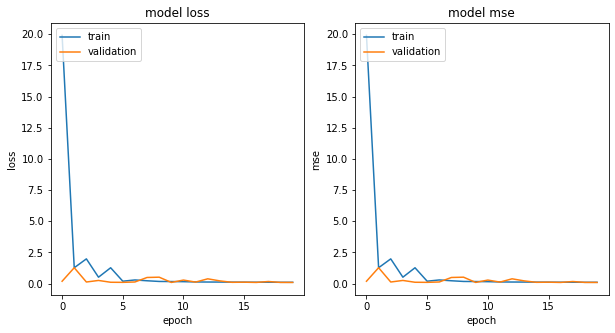

In [19]:
# Use matplotlib to draw the model's loss curves for training and validation
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');

# Plotting
plot_curves(history, ['loss', 'mse'])

<H3> PREDICTION </H3>
<h4>Using TEST data to make PRICE prediction & compare ACTUAL vs PREDICTED</h4>
 

In [ ]:
inp = {'Suburb':'BAULKHAM HILLS','Type': 'House','Method': 'auction','Bedrooms':  4, 'Bathrooms':  2, 'Cars':  1, 'Area':  450,'Latitude':  -33.77157324083317 ,'Longitude':  150.98026592490677,'Distance':  26.5, 'Year':  2022}
input_df = pd.DataFrame.from_dict(inp)
inp_ds = tf.data.Dataset.from_tensor_slices((dict(input_df)))
inp_ds = inp_ds.batch(1)

pred = model.predict(inp_ds)
print(pred)

In [20]:
def measure_performance(model,vers):
    predictions = model.predict(test_ds)
  
    # test["Price"] = round(10 ** test['LogPrice'])
    # predictions = np.round(10 ** predictions)
    
    test['Price']= round(special.inv_boxcox(test['BoxPrice'], lam))
    predictions = np.round(special.inv_boxcox(predictions, lam))

    #
    for i in range(30):
        diff = round((predictions[i][0] - test['Price'].iloc[i])/1000)
        print('PREDICTION: ${0}'.format(predictions[i][0]) + '   ACTUAL: '+format(test['Price'].iloc[i]) + f' DIFFERENCE: ${diff}')


    x = range(0,4200000)
    y = x
    plt.scatter(test['Price'].iloc[0:len(predictions)],predictions[0:len(predictions)])
    plt.title("ACTUAL VS PREDICTED PRICE")
    plt.xlabel("ACTUAL PRICE: $")
    plt.ylabel("PREDICATED PRICE: $")
    plt.plot(x,y,'red')
    plt.savefig(f"model{vers}_rmse.png",bbox_inches = "tight")
    rmse = np.sqrt(mean_squared_error(test["Price"],predictions))
    with open("RMSE.txt", "a") as text_file:
        n = text_file.write(f"ROOT MEAN SQUARE ERROR ON TEST DATA for MODEL{vers}: ${rmse}\n")
    text_file.close()  
    print(f"ROOT MEAN SQUARE ERROR ON TEST DATA: ${rmse}")

676/676 [==============================] - 2s 3ms/step
PREDICTION: $541992.0   ACTUAL: 632500.0 DIFFERENCE: $-91
PREDICTION: $1386316.0   ACTUAL: 1330000.0 DIFFERENCE: $56
PREDICTION: $889194.0   ACTUAL: 962000.0 DIFFERENCE: $-73
PREDICTION: $687671.0   ACTUAL: 660000.0 DIFFERENCE: $28
PREDICTION: $670859.0   ACTUAL: 960000.0 DIFFERENCE: $-289
PREDICTION: $532962.0   ACTUAL: 460000.0 DIFFERENCE: $73
PREDICTION: $1210614.0   ACTUAL: 1395000.0 DIFFERENCE: $-184
PREDICTION: $906310.0   ACTUAL: 1410000.0 DIFFERENCE: $-504
PREDICTION: $1437193.0   ACTUAL: 1715000.0 DIFFERENCE: $-278
PREDICTION: $1669841.0   ACTUAL: 1950000.0 DIFFERENCE: $-280
PREDICTION: $1213730.0   ACTUAL: 1150000.0 DIFFERENCE: $64
PREDICTION: $373162.0   ACTUAL: 330000.0 DIFFERENCE: $43
PREDICTION: $651178.0   ACTUAL: 512500.0 DIFFERENCE: $139
PREDICTION: $701066.0   ACTUAL: 915000.0 DIFFERENCE: $-214
PREDICTION: $1934998.0   ACTUAL: 3350000.0 DIFFERENCE: $-1415
PREDICTION: $852277.0   ACTUAL: 655000.0 DIFFERENCE: $197
P

676/676 [==============================] - 2s 3ms/step
PREDICTION: $564638.0   ACTUAL: 632500.0 DIFFERENCE: $-68
PREDICTION: $1508098.0   ACTUAL: 1330000.0 DIFFERENCE: $178
PREDICTION: $929358.0   ACTUAL: 962000.0 DIFFERENCE: $-33
PREDICTION: $752401.0   ACTUAL: 660000.0 DIFFERENCE: $92
PREDICTION: $717296.0   ACTUAL: 960000.0 DIFFERENCE: $-243
PREDICTION: $586049.0   ACTUAL: 460000.0 DIFFERENCE: $126
PREDICTION: $1302186.0   ACTUAL: 1395000.0 DIFFERENCE: $-93
PREDICTION: $987514.0   ACTUAL: 1410000.0 DIFFERENCE: $-422
PREDICTION: $1565703.0   ACTUAL: 1715000.0 DIFFERENCE: $-149
PREDICTION: $1800335.0   ACTUAL: 1950000.0 DIFFERENCE: $-150
PREDICTION: $1125417.0   ACTUAL: 1150000.0 DIFFERENCE: $-25
PREDICTION: $411799.0   ACTUAL: 330000.0 DIFFERENCE: $82
PREDICTION: $730965.0   ACTUAL: 512500.0 DIFFERENCE: $218
PREDICTION: $740712.0   ACTUAL: 915000.0 DIFFERENCE: $-174
PREDICTION: $1927983.0   ACTUAL: 3350000.0 DIFFERENCE: $-1422
PREDICTION: $901407.0   ACTUAL: 655000.0 DIFFERENCE: $246

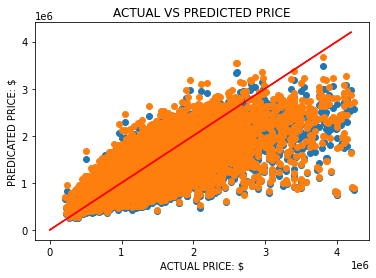

In [21]:

for mod_vers in range(models[-2],models[-1]+1):
    model = tf.keras.models.load_model(f"saved_models/{mod_vers}")
    measure_performance(model,mod_vers)
    

# model8 = tf.keras.models.load_model('saved_models/9')
# model9 = tf.keras.models.load_model('saved_models/9')
# model10 = tf.keras.models.load_model('saved_models/10')
# model11 = tf.keras.models.load_model('saved_models/11')


# Check its architecture
# model1.summary()

<h4> SERVE MODEL IN PRODUCTION (HEROKU)</h4>
<h5> Using TF Serving Docker Container </h5>

In [ ]:
%%bash
heroku auth:login
heroku container:login
heroku container:push web -a tf-serve-model
heroku container:release web -a tf-serve-model
heroku logs -a tf-serve-model --tail

<h4> SERVE MODEL LOCALLY FOR TESTING PURPOSES ONLY (OPTIONAL) </h4>
<h5> Using TF Serving Docker Container </h5>

In [ ]:
#docker run -it -v /home/khaled/AUTOMATION-EXCEL\:/tf_serving -p 8601:8601 --entrypoint /bin/bash tensorflow/serving
#tensorflow_model_server --rest_api_port=8601 --model_name=melb_price --model_base_path=/tf_serving/saved_models/

client = docker.from_env()
container = client.containers.run(image = "tensorflow/serving", ports = {8601:8601},volumes = ['/home/khaled/MLrealestate:/tf_serving'], detach=True)
container.exec_run('/bin/bash')
print(container.exec_run('ls'))
container.exec_run('tensorflow_model_server --rest_api_port=8601 --model_name=real_estate_price_est --model_base_path=/tf_serving/saved_models/',detach = True)

In [ ]:
iterator = examples['train_ds'].__iter__()
next_element = iterator.get_next()
pt = next_element[0]
en = next_element[1]
print(pt.numpy())
print(en.numpy())

In [ ]:
input = list(inp.values())
data = {"instances": [inp]}
test.head(5)


<h4> API CALL FOR PREDICTION</h4>
<h5>  REST API POST for LOCAL TF SERVING CONTAINER - MODEL NAME: real_estate_est</h5>

In [ ]:
#%%bash
#curl -d '{"instances": [[0.25,0.07553956834532373,0.0,0.25,0.0,0.1937046004842615,0.9103448275862069,0.516068393160683,0.4633053471477789,1.0]]}' \
#-X POST http://localhost:8601/v1/models/melb_price:predict

r = requests.post(url="http://localhost:8601/v1/models/real_estate_price_est:predict", data=json.dumps(data))
print(r.json())